In [343]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from celldreamer.eval.eval_utils import join_real_generated

import itertools
from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
from tqdm import tqdm
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right
from celldreamer.paths import DATA_DIR
from celldreamer.eval.distribution_distances import compute_distribution_distances

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

import seaborn as sns
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt 
matplotlib.rcdefaults()

## Step 1: Initialize data

Dataloader for NeurIPS dataset with donor as a conditioner

In [344]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'tabula_muris' / 'tabula_muris_test.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['mouse.id', 'tissue'],
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.10],
                    'cov_embedding_dimensions': 128, 
                    'multimodal': False, 
                    'is_binarized': False,
                    'theta_covariate': 'tissue', 
                    'size_factor_covariate': 'mouse.id', 
                    'guidance_weights': {'tissue': 1, 'mouse.id': 1}
                 }

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        multimodal=dataset_config["multimodal"],
                        is_binarized=dataset_config["is_binarized"]
                      )

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [345]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False, 
    "multimodal": False,
    "is_binarized": False}


state_dict_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/off_train_autoencoder_tabula_muris_whole_genome/df8d1d1a-085d-403c-8323-beb4c5a3f4cd/checkpoints/epoch_79.ckpt"

In [346]:
encoder_model = EncoderModel(in_dim=in_dim,
                              n_cat=10,
                              conditioning_covariate=dataset_config["theta_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Initializae two FM models - one with single guide

In [347]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

Guided

In [348]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/GUIDED_MULTILAB_TABULA/d728053e-845a-4694-8a2d-87b1edacba57/checkpoints/last.ckpt")

guided_denoising_model = ckpt["hyper_parameters"]["denoising_model"]
guided_denoising_model.multimodal = False
guided_feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Unguided

In [349]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/experiments/UNGUIDED_MULTILAB_TABULA/4de85a96-f91e-4c25-aa29-0a26605d24e9/checkpoints/last.ckpt")

unguided_denoising_model = ckpt["hyper_parameters"]["denoising_model"]
unguided_denoising_model.multimodal = False
unguided_feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

### FM models

Guided

In [350]:
guided_generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=guided_denoising_model,
            feature_embeddings=guided_feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=guided_denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'tissue': 2, 'mouse.id': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

guided_generative_model.load_state_dict(ckpt["state_dict"])
guided_generative_model.to("cuda")
guided_generative_model.denoising_model.guided_conditioning = True

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


In [351]:
unguided_generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=unguided_denoising_model,
            feature_embeddings=unguided_feature_embeddings,
            plotting_folder=None,
            in_dim=50,
            size_factor_statistics=size_factor_statistics,
            covariate_list=dataset_config["covariate_keys"],
            theta_covariate=dataset_config["theta_covariate"],
            size_factor_covariate=dataset_config["size_factor_covariate"],
            model_type=unguided_denoising_model.model_type, 
            encoder_type=dataset_config["encoder_type"],
            multimodal=dataset_config["multimodal"],
            is_binarized=False,
            modality_list=None,
            guidance_weights={'tissue': 2, 'mouse.id': 2},
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

unguided_generative_model.load_state_dict(ckpt["state_dict"])
unguided_generative_model.to("cuda")

FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=19734, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

## Read anndata

In [352]:
data_path = "/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/processed_full_genome/tabula_muris/tabula_muris_test.h5ad"
adata_original = sc.read_h5ad(data_path)
# adata_original.X = adata_original.layers["X_counts"].copy()
# sc.pp.normalize_total(adata_original, target_sum=1e4)
# sc.pp.log1p(adata_original)
# sc.tl.pca(adata_original)
# sc.pp.neighbors(adata_original)
# sc.tl.umap(adata_original)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


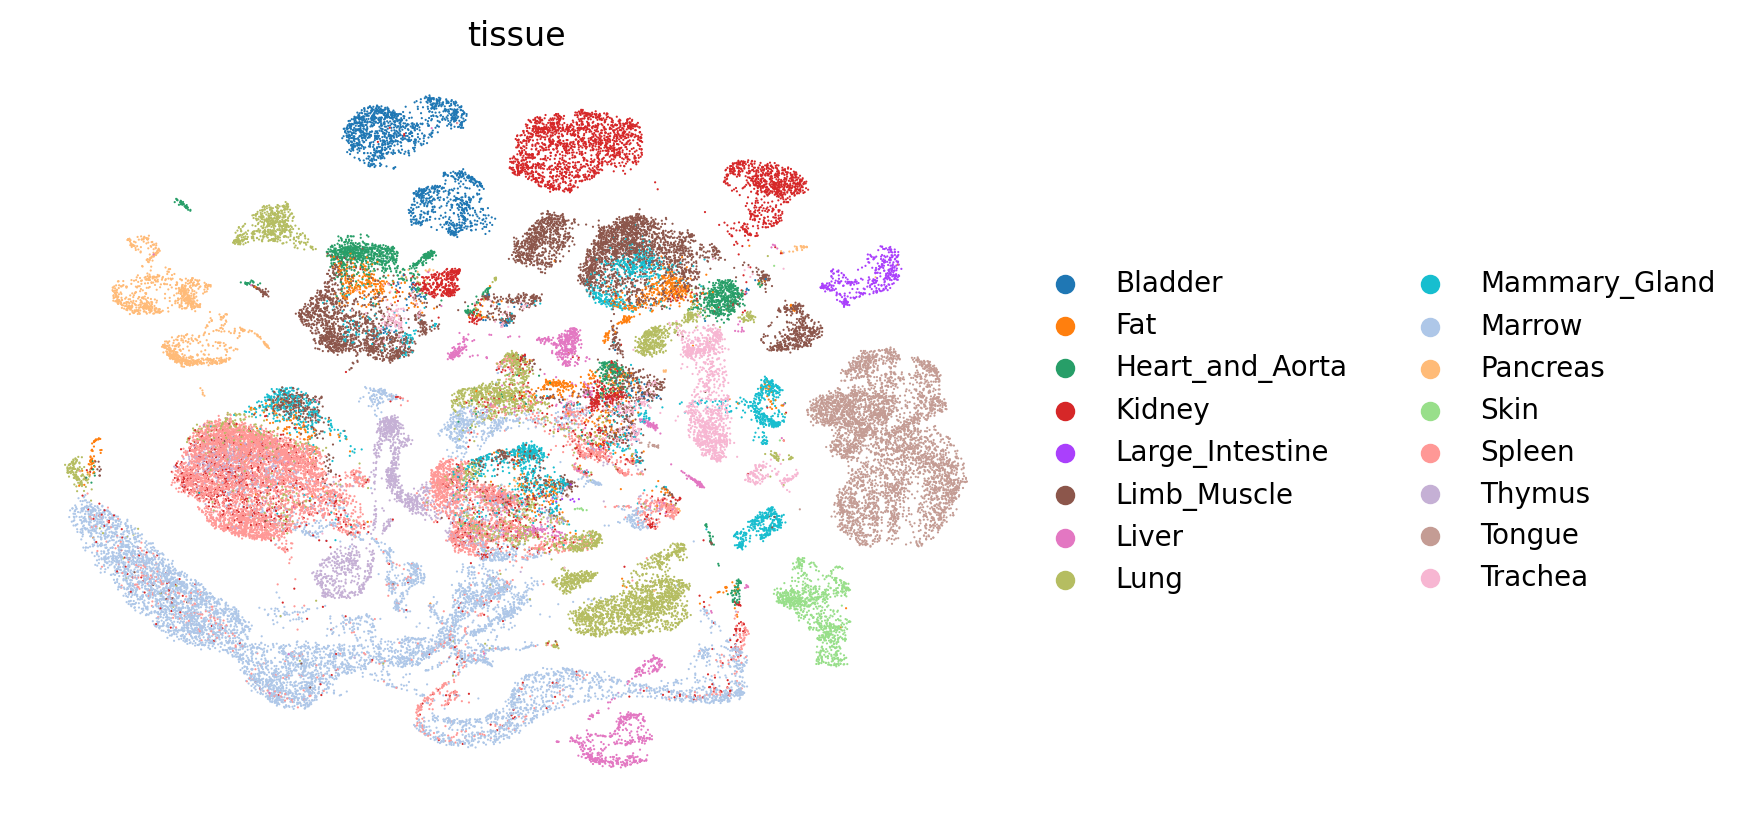

In [353]:
sc.pl.umap(adata_original, color="tissue")

# COMBINATION OF CONDITIONS 

Generate all combinations of conditions

In [354]:
all_combs = {}

for i in dataset.id2cov["tissue"]:
    for j in dataset.id2cov["mouse.id"]:
        freq = adata_original.obs.loc[np.logical_and(adata_original.obs["tissue"]==i, 
                                        adata_original.obs["mouse.id"]==j)].shape[0]
        all_combs[(i,j)]=freq

# Kee only the cobinations with certain frequency on 
all_combs = {key:val for key,val in all_combs.items() if val>50}

In [355]:
# Guidance weights (same for both attributes)
# guidance_weights = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
guidance_weights = [1]
guidance_weights = list(itertools.product(guidance_weights, repeat=2))

In [356]:
# # Guidance weights (same for both attributes)
# # guidance_weights = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 20]
# guidance_weights = [1, 2, 3, 4]

results_guided = {"Weight": [],
                  "Metric type": [],
                  "Value": []}

for comb in tqdm(all_combs):
    # Get combination of attributes 
    covariates_cell_types = comb[0]
    covariates_donor = comb[1]
    
    # Get the labels
    condition_id_ct = dataset.id2cov["tissue"][covariates_cell_types]
    condition_id_donor = dataset.id2cov["mouse.id"][covariates_donor]
    
    # Get the labels 
    adata_cond = adata_original[np.logical_and(adata_original.obs.tissue==covariates_cell_types, 
                                               adata_original.obs["mouse.id"]==covariates_donor)]
    n_to_generate = adata_cond.shape[0]
    
    classes = {"tissue": condition_id_ct*torch.ones(n_to_generate).long(), 
                "mouse.id": condition_id_donor*torch.ones(n_to_generate).long()}
    
    classes_str = {"tissue": [covariates_cell_types for n in range(n_to_generate)], 
                    "mouse.id": [covariates_donor for n in range(n_to_generate)]}

    # Log size factor to condition generation 
    log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

    for weight in guidance_weights:
        guided_generative_model.guidance_weights["tissue"] = weight[0]
        guided_generative_model.guidance_weights["mouse.id"] = weight[1]
        
        guided_X_generated = guided_generative_model.sample(batch_size=n_to_generate,
                                                            n_sample_steps=100, 
                                                            theta_covariate="tissue", 
                                                            size_factor_covariate="tissue",
                                                            conditioning_covariates=["tissue", "mouse.id"],
                                                            covariate_indices=classes, 
                                                            log_size_factor=log_size_factors)

        # Guided metrics 
        guided_adata_generated = sc.AnnData(X=guided_X_generated.to("cpu").numpy())
        sc.pp.normalize_total(guided_adata_generated, target_sum=1e4)
        sc.pp.log1p(guided_adata_generated)
        guided_X_generated = guided_adata_generated.X.dot(adata_cond.varm["PCs"])
        guided_score = compute_distribution_distances(torch.tensor(guided_X_generated), 
                                                           torch.tensor(adata_cond.obsm["X_pca"]))

        results_guided["Weight"].append(f"{weight[0]}_{weight[1]}")
        results_guided["Metric type"].append("2-WD")
        results_guided["Value"].append(guided_score["2-Wasserstein"])
        results_guided["Weight"].append(f"{weight[0]}_{weight[1]}")
        results_guided["Metric type"].append("Linear MMD")
        results_guided["Value"].append(guided_score["Linear_MMD"])
        results_guided["Weight"].append(f"{weight[0]}_{weight[1]}")
        results_guided["Metric type"].append("Poly MMD")
        results_guided["Value"].append(guided_score["Poly_MMD"])
        results_guided["Weight"].append(f"{weight[0]}_{weight[1]}")
        results_guided["Metric type"].append("RBF MMD")
        results_guided["Value"].append(guided_score["RBF_MMD"])

    unguided_X_generated = unguided_generative_model.sample(batch_size=n_to_generate,
                                            n_sample_steps=100, 
                                            theta_covariate="tissue", 
                                            size_factor_covariate="tissue",
                                            conditioning_covariates=["tissue", "mouse.id"],
                                            covariate_indices=classes, 
                                            log_size_factor=log_size_factors)

    # Unguided metrics 
    unguided_adata_generated = sc.AnnData(X=unguided_X_generated.to("cpu").numpy())
    sc.pp.normalize_total(unguided_adata_generated, target_sum=1e4)
    sc.pp.log1p(unguided_adata_generated)
    unguided_X_generated = unguided_adata_generated.X.dot(adata_cond.varm["PCs"])
    unguided_score = compute_distribution_distances(torch.tensor(unguided_X_generated), 
                                                       torch.tensor(adata_cond.obsm["X_pca"]))

    results_guided["Weight"].append("Joint")
    results_guided["Metric type"].append("Linear MMD")
    results_guided["Value"].append(unguided_score["Linear_MMD"])
    results_guided["Weight"].append("Joint")
    results_guided["Metric type"].append("Poly MMD")
    results_guided["Value"].append(unguided_score["Poly_MMD"])
    results_guided["Weight"].append("Joint")
    results_guided["Metric type"].append("RBF MMD")
    results_guided["Value"].append(unguided_score["RBF_MMD"])
    results_guided["Weight"].append("Joint")
    results_guided["Metric type"].append("2-WD")
    results_guided["Value"].append(unguided_score["2-Wasserstein"])

100%|██████████| 142/142 [07:26<00:00,  3.14s/it]


In [357]:
torch.tensor(guided_X_generated)

tensor([[-1.2285e+01, -3.9172e+01, -2.4774e+00,  ...,  1.3468e+00,
         -1.2056e+00, -1.7983e+00],
        [-9.7662e+00, -3.7662e+01, -8.7091e-02,  ...,  6.7276e-01,
         -1.7658e+00, -1.8075e+00],
        [-1.0700e+01, -3.8938e+01,  3.0608e-01,  ...,  9.0192e-02,
         -1.7533e-01, -4.6121e+00],
        ...,
        [-9.5439e+00, -3.8806e+01, -3.0890e+00,  ..., -4.8309e-01,
         -3.6584e+00, -2.6530e+00],
        [-9.5222e+00, -3.7556e+01, -5.3726e+00,  ..., -4.2990e-01,
         -1.1434e+00, -1.8566e+00],
        [-1.2756e+01, -3.9839e+01, -1.0635e-01,  ..., -1.0239e-02,
         -1.5871e-01, -1.4942e+00]])

In [358]:
torch.tensor(adata_cond.obsm["X_pca"])

tensor([[-12.2947,   2.8419,  -3.5646,  ...,  -0.5561,   0.7774,   0.3390],
        [-13.8210,   9.4001,  -8.7538,  ...,   0.0976,   0.0252,  -1.6865],
        [  5.1753,  -4.6651,  -6.5310,  ...,   0.6801,   1.5066,  -0.6081],
        ...,
        [-14.0890,   4.1608,  -2.9321,  ...,  -2.1025,  -0.3105,   0.1524],
        [-14.5970,   6.2517,  -7.7467,  ...,   2.9379,   2.1016,   1.5870],
        [-13.5119,   1.5226,  -4.9702,  ...,   0.4684,   0.4518,  -0.8463]])

In [359]:
results_df = pd.DataFrame(results_guided)

In [360]:
results_df.groupby(["Metric type", "Weight"]).mean()

Value
Metric type Weight              
2-WD        1_1     5.562834e+01
            Joint   4.549439e+01
Linear MMD  1_1     2.749840e+03
            Joint   1.933666e+03
Poly MMD    1_1     5.608788e+06
            Joint   5.237789e+06
RBF MMD     1_1     6.832419e-01
            Joint   6.039360e-01

In [361]:
# results_df = pd.read_csv("/home/icb/alessandro.palma/environment/cfgen/project_folder/celldreamer/experiments_multiattr/tabula_muris.csv")

In [362]:
results_df.loc[results_df.Weight=="Joint", "Weight"] = "Joint cond."

# Make plots 

In [363]:
import seaborn as sns

In [364]:
# Make values floats
results_df["Value"] = [float(i) for i in results_df["Value"]] 

In [365]:
# Unique numbers 
unique_numbers = [i for i in results_df["Weight"] if i!="Joint cond."]

In [366]:
latex_labs = [r'$\omega_{\mathrm{tissue}}=$'+str(i)+r', $\omega_{\mathrm{mouse ID}}=$'+str(i) if i!="Joint cond." else i for i in results_df["Weight"]]
indexes = np.unique(latex_labs, return_index=True)[1]
unique_labs = ["Joint cond."]+[latex_labs[index] for index in sorted(indexes) if latex_labs[index]!="Joint cond."]

results_df["Formatted weights"] = latex_labs

In [367]:
# plt.figure(figsize=(5,3))
# ax = sns.barplot(data=results_df.loc[results_df["Metric type"]=="2-WD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
# plt.ylabel("Value ($\downarrow)$")
# plt.title("2-Wasserstein distance - Tabula Muris")
# plt.xlabel("Guidance weights")
# plt.savefig('2_wd_tabula_muris.svg', format='svg', bbox_inches='tight')
# plt.show()

In [368]:
# plt.figure(figsize=(5,3))
# ax = sns.barplot(data=results_df.loc[results_df["Metric type"]=="MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
# plt.ylabel("Value ($\downarrow)$")
# plt.title("MMD - Tabula Muris")
# plt.xlabel("Guidance weights")
# plt.savefig('2_mmd_tabula_muris.svg', format='svg', bbox_inches='tight')
# plt.show()

In [369]:
# results_df.to_csv("/home/icb/alessandro.palma/environment/cfgen/project_folder/celldreamer/experiments_multiattr/tabula_muris.csv")

In [370]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="2-WD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [371]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="RBF MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [372]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="Linear MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

In [373]:
# sns.barplot(data=results_df.loc[results_df["Metric type"]=="Poly MMD"],
#              x="Formatted weights",
#              y="Value", order=unique_labs, palette="tab20c")
# plt.xticks(rotation=90)

# plt.show()

# Put together

In [374]:
guided_adata_generated.X.max(1)

array([5.1395545, 5.225481 , 5.014396 , 5.29231  , 5.010597 , 5.458952 ,
       4.8440514, 5.1943855, 5.3798347, 5.9757357, 5.146622 , 5.673536 ,
       5.27911  , 5.2565274, 5.0256114, 5.778183 , 5.1717052, 5.481933 ,
       5.4395523, 5.1821337, 6.0402484, 5.4232736, 5.5756664, 5.411239 ,
       5.1521883, 5.439063 , 5.333995 , 5.603376 , 4.8655844, 5.5288825,
       5.3355575, 5.344823 , 5.030822 , 5.8253813, 5.989851 , 4.934053 ,
       4.835073 , 5.1097617, 5.327187 , 6.9838815, 5.128768 , 5.401235 ,
       5.299367 , 6.6504025, 5.464161 , 5.2611   , 5.085228 , 5.436603 ,
       5.3247194, 5.654681 , 5.262491 , 6.3288093, 5.5999894, 5.423495 ,
       5.641249 , 4.9992504, 5.067884 , 5.2597623, 4.9866242, 5.062179 ,
       5.362867 , 5.1029954, 4.974125 , 5.1801353, 5.9240355, 4.8877463,
       6.0358763, 5.2974257, 5.314547 , 4.9626837, 5.7159576, 5.201209 ,
       5.049729 , 5.209973 , 5.099367 , 5.0941043, 5.217502 , 5.0947447,
       5.1712513, 4.8798923, 5.321863 , 5.2674117, 

In [375]:
adata_cond.X.A.max(1)

array([6.4191804, 6.5081177, 6.029458 , 6.3071294, 6.4895725, 4.686998 ,
       6.5571103, 5.614536 , 6.790343 , 7.2772393, 6.561689 , 6.0704184,
       5.6741004, 6.669985 , 6.70388  , 7.105731 , 6.432636 , 6.4465165,
       5.4877653, 6.5124483, 5.1017637, 7.193502 , 6.20548  , 6.750825 ,
       6.8416705, 6.248332 , 6.2568827, 5.2726645, 6.0342803, 6.06469  ,
       7.0540857, 6.1590285, 6.9241905, 7.20643  , 5.4967775, 6.2153935,
       5.8826632, 6.902564 , 5.7965508, 6.224119 , 5.68903  , 6.5977693,
       6.7701774, 6.9238896, 5.4293075, 6.580881 , 5.9726067, 5.8359623,
       7.441042 , 6.242761 , 5.9012814, 6.0201616, 6.4879026, 6.493162 ,
       5.823063 , 6.307538 , 5.8360424, 5.8931975, 6.375016 , 6.2736945,
       6.1200256, 6.3182874, 6.523867 , 7.315054 , 5.987462 , 6.7909546,
       7.0902677, 6.0570226, 6.1451273, 6.3742776, 6.150826 , 6.759973 ,
       7.112854 , 7.078261 , 7.263977 , 7.0817327, 6.779822 , 6.7809944,
       6.0125995, 6.838465 , 6.0635495, 6.976032 , 

In [388]:
adata_try = sc.AnnData(X=np.concatenate([unguided_adata_generated.X, 
                                            adata_cond.X.A
                                        ]),
                      obs = {"data_type": ["fake" for _ in range(len(guided_adata_generated))] +
                                              ["true"  for _ in range(len(adata_cond))]
                                          })

In [389]:
guided_adata_generated.X.sum(1).mean()

2305.0203

In [390]:
adata_cond.X.A.sum(1).mean()

2495.362

In [391]:
sc.tl.pca(adata_try)
sc.pp.neighbors(adata_try)
sc.tl.umap(adata_try)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


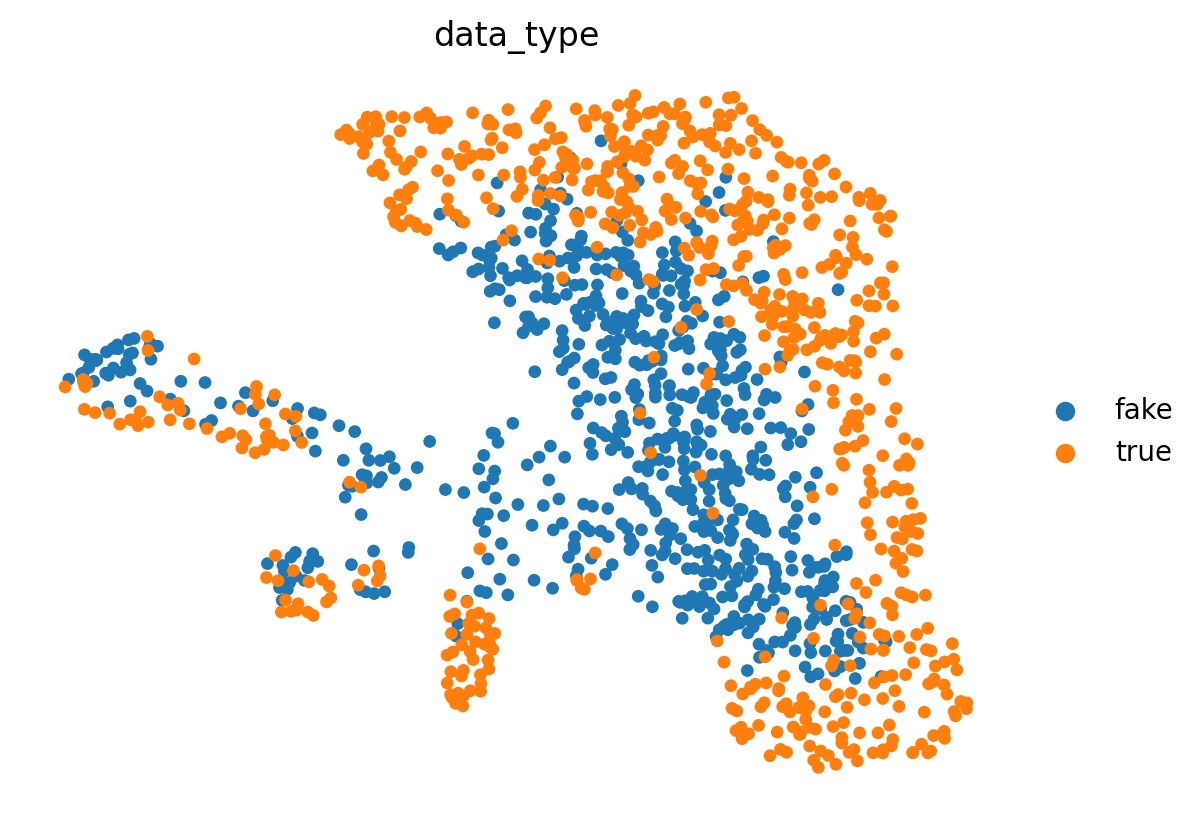

In [392]:
sc.pl.umap(adata_try, color="data_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


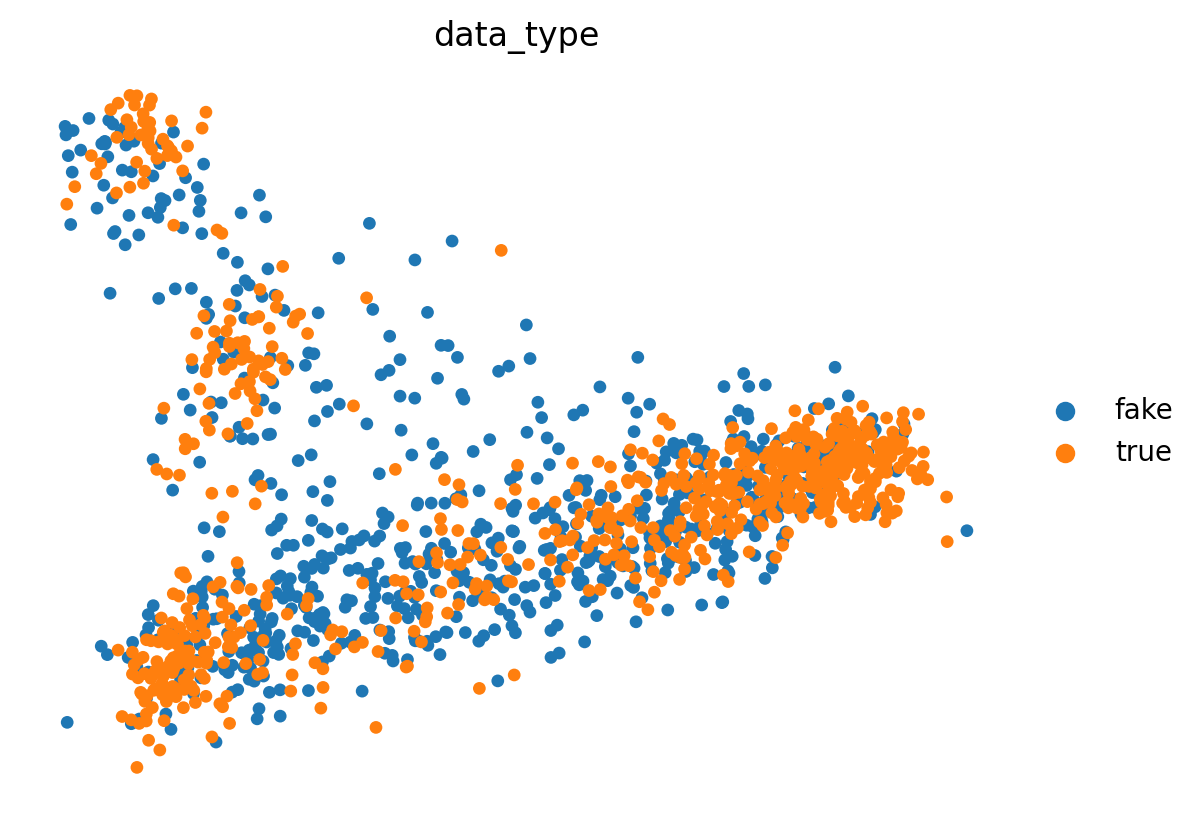

In [393]:
sc.pl.pca(adata_try, color="data_type")